In [381]:
import pyedflib
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
import math
from scipy.signal import butter, sosfilt, lfilter, sosfiltfilt, sosfreqz
from scipy.fft import fft, fftfreq
import scipy
from sklearn import preprocessing
import eeglib
from scipy.signal import welch
from scipy.integrate import simps
import pywt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import metrics

In [2]:
from load_data import Subject_Session_Data
# from preprocess import butter_bandpass_filter

In [415]:
work_dir = os.path.dirname(os.path.dirname(os.getcwd()))
dataset_dir = os.path.join(work_dir, "enterface06_EMOBRAIN", "Data")
dataset_common_dir = os.path.join(dataset_dir, "Common")
dataset_EEG_dir = os.path.join(dataset_dir, "EEG")
dataset_fNIRS_dir = os.path.join(dataset_dir, "fNIRS")

print("working with dataset directory:", dataset_dir)

# Construct the search pattern
pattern = os.path.join(dataset_EEG_dir, "*.bdf")

# Find all files in the directory matching the pattern
bdf_files = glob.glob(pattern)

count = 1
data_list = []
for file in bdf_files:
        # Open the BDF file
        try:
                with pyedflib.EdfReader(file) as f:
                        # marks = []
                        print("reading file :", count)
                        participant_index = file.find("Part")
                        session_index = file.find("SES")
                        participant_number = int(file[participant_index+4])
                        # print("Participant number:", participant_number)
                        session_number = int(file[session_index+3])
                        # print("Session number:", session_number)
                        if participant_number == 2 and session_number == 1:
                                continue
                        fi = open(file+".mrk", "r")
                        fi.readline()
                        inferred_temp_marks = []
                        for line in fi:
                                temp_marks = line.split('\t')[1:]
                                temp_marks[-1] = temp_marks[-1][:-1]
                                if temp_marks[-1] == '"255"':
                                        if temp_marks[0] == temp_marks[1]:
                                                inferred_temp_marks.append(int(temp_marks[0]))
                                        else:
                                                print("Irregular:", temp_marks)
                        print(len(inferred_temp_marks))
                        block_sample_ranges = []
                        for trigger in inferred_temp_marks:
                                if participant_number == 1 and session_number == 1:
                                        start_index = trigger + 768
                                        end_index = start_index + 3200
                                        block_sample_ranges.append((start_index,end_index))
                                else:
                                        start_index = trigger + 3072
                                        end_index = start_index + 12800
                                        block_sample_ranges.append((start_index,end_index))

                        data_list.append(Subject_Session_Data(f, count, participant_number, session_number, inferred_temp_marks, block_sample_ranges))
                        '''
                        # Get general information
                        print("reading file :", count)
                        print("File duration in seconds:", f.file_duration)
                        print("Number of signals:", f.signals_in_file)
                        signal_labels = f.getSignalLabels()
                        print("Signal labels:", signal_labels)

                        # Read data from each signal
                        for i in range(f.signals_in_file):
                                data = f.readSignal(i)
                                print(f"Data from signal {signal_labels[i]}:", data)
                        '''
        except (OSError):
                print("reading file :", count, "FAIL")
        count += 1

emotion_classes = os.path.join(dataset_common_dir, "IAPS_Classes_EEG_fNIRS.txt")
emotion_file = open(emotion_classes, "r")
session1 = []
session2 = []
session3 = []
for line in emotion_file:
        temp_emotions = line.split("\t")
        temp_emotions[-1] = temp_emotions[-1][:-1]
        session1.append(temp_emotions[0])
        session2.append(temp_emotions[1])
        session3.append(temp_emotions[2])

for subject_session in data_list:
        if subject_session.session_number == 1:
                subject_session.emotions = session1
        elif subject_session.session_number == 2:
                subject_session.emotions = session2
        elif subject_session.session_number == 3:
                subject_session.emotions = session3

working with dataset directory: /Users/magizhshankar/Documents/CS 545/Final Project/enterface06_EMOBRAIN/Data
reading file : 1
30
reading file : 2
reading file : 2
30
reading file : 3
30
reading file : 4
30
reading file : 5
30
reading file : 6
30
reading file : 7
30
reading file : 8
30
reading file : 9
30
reading file : 10
30
reading file : 11
30
reading file : 12
30
reading file : 13
30
reading file : 14
30


In [106]:
data_list[4].display_info()

file number: 5
File duration in seconds: 1338
Number of signals: 72
Number of samples: 1370112
Participant number: 4
Session number: 3
Emotions ['Pos', 'Neg', 'Calm', 'Pos', 'Pos', 'Neg', 'Calm', 'Neg', 'Calm', 'Calm', 'Neg', 'Neg', 'Calm', 'Pos', 'Pos', 'Calm', 'Neg', 'Pos', 'Neg', 'Calm', 'Pos', 'Calm', 'Calm', 'Neg', 'Pos', 'Calm', 'Pos', 'Pos', 'Neg', 'Neg']


In [5]:
test_signal = data_list[0]
fs = 1024

In [6]:
def plot_signal(data, title):
    t = np.arange(data.shape[0])
    plt.figure(figsize=(12,5))
    plt.plot(t,data)
    plt.xlim([t[0],t[-1]])
    plt.ylim([min(data), max(data)])
    plt.xlabel('time (sec)')
    plt.grid()
    plt.title(title)
    plt.show()

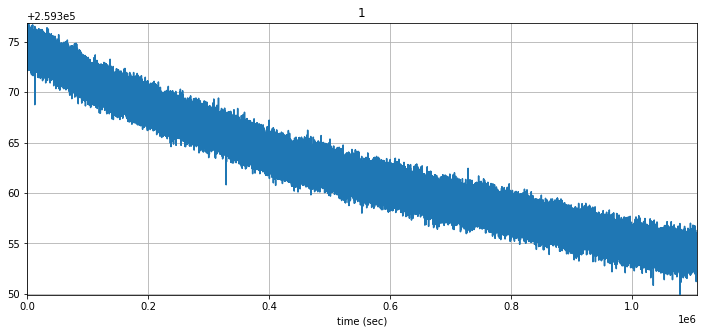

In [28]:
test_signal_labels = test_signal.signal_labels
test_data_dic = test_signal.data_dictionary
index = 1
test_data = test_data_dic[test_signal_labels[index]]
# test_data = test_data - np.mean(test_data)
plot_signal(test_data, '1')

In [29]:
def plotSpectrum(y,Fs):
 """
 Plots a Single-Sided Amplitude Spectrum of y(t)
 """
 n = len(y) # length of the signal
 k = scipy.arange(n)
 T = n/Fs
 frq = k/T # two sides frequency range
 frq = frq[range(int(n/2))][:100000] # one side frequency range

 Y = fft(y)/n # fft computing and normalization
 Y = Y[range(int(n/2))][:100000]
 
 plt.plot(frq,abs(Y),'r') # plotting the spectrum
 plt.xlabel('Freq (Hz)')
 plt.ylabel('|Y(freq)|')

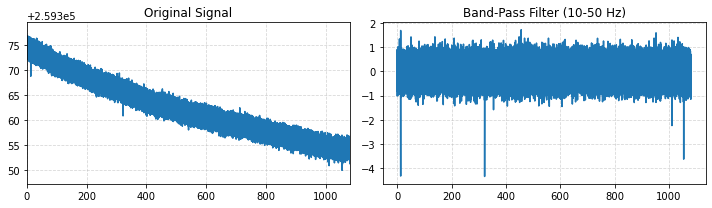

In [31]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 3))
ax1.plot(times, test_data)
ax1.set_title("Original Signal")
ax1.margins(0, .1)
ax1.grid(alpha=.5, ls='--')
filtered = filtered - np.mean(filtered)
ax2.plot(times, filtered)
ax2.set_title("Band-Pass Filter (10-50 Hz)")
ax2.grid(alpha=.5, ls='--')
plt.tight_layout()
plt.show()

<ipython-input-25-b7b995159154>:6: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  k = scipy.arange(n)


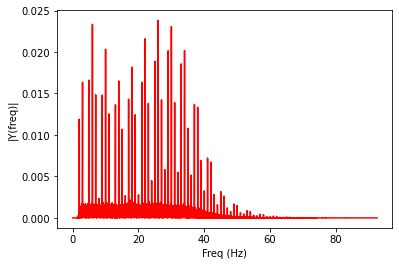

In [26]:
plotSpectrum(filtered, fs)

<ipython-input-25-b7b995159154>:6: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  k = scipy.arange(n)


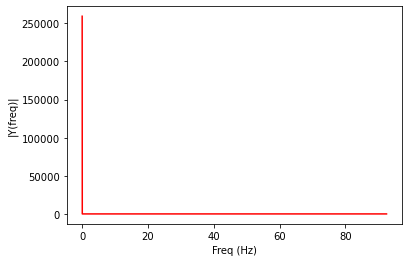

In [27]:
plotSpectrum(test_data, fs)

In [416]:
def bandpower(data, sf, band, window_sec=None, relative=False):
    """Compute the average power of the signal x in a specific frequency band.

    Parameters
    ----------
    data : 1d-array
        Input signal in the time-domain.
    sf : float
        Sampling frequency of the data.
    band : list
        Lower and upper frequencies of the band of interest.
    window_sec : float
        Length of each window in seconds.
        If None, window_sec = (1 / min(band)) * 2
    relative : boolean
        If True, return the relative power (= divided by the total power of the signal).
        If False (default), return the absolute power.

    Return
    ------
    bp : float
        Absolute or relative band power.
    """
    
    band = np.asarray(band)
    low, high = band

    # Define window length
    if window_sec is not None:
        nperseg = window_sec * sf
    else:
        nperseg = (2 / low) * sf

    # Compute the modified periodogram (Welch)
    freqs, psd = welch(data, sf, nperseg=nperseg)

    # Frequency resolution
    freq_res = freqs[1] - freqs[0]

    # Find closest indices of band in frequency vector
    idx_band = np.logical_and(freqs >= low, freqs <= high)

    # Integral approximation of the spectrum using Simpson's rule.
    bp = simps(psd[idx_band], dx=freq_res)

    if relative:
        bp /= simps(psd, dx=freq_res)
    return bp

In [640]:
class EEGFeatureExtraction:
    
    def __init__(self, data, fs=1024):
        self.data = data
        self.fs = fs
        self.num_samples = len(data)
        self.num_channels = data[1].num_channels
        self.num_truncations = len(data[1].block_sample_ranges)
        self.target_channels = ['F3'] #, 'F4', 'T7'] # , 'Fp1', 'Fp2', 'T8', 'F7', 'F8', 'O1', 'P7', 'P8', 'O2']
        print()

    def display_info(self):
            # samples = {}
            print("Number of samples:", self.num_samples)
            print("Number of channels:", self.num_channels)
            print("Number of truncations:", self.num_truncations)
            print("Target channels:", self.target_channels)

    def extract_features(self):
        results = np.zeros(shape = (self.num_samples, self.num_truncations, len(self.target_channels) * 3200))
        print(results.shape)
        for sample_id, sample in enumerate(self.data):
            for band_id, truncation_range in enumerate(sample.block_sample_ranges):
                features = []
                for channel_id, channel in enumerate(self.target_channels):
                    assert channel in sample.signal_labels, channel + " target channel is not present in the sample data!"
                    channel_signal = sample.data_dictionary[channel]
                    truncation = channel_signal[truncation_range[0]:truncation_range[1]]
                    if len(truncation) == 12800:
                         truncation = truncation[::4]
                    filtered = eeglib.preprocessing.bandPassFilter(truncation, sampleRate=self.fs, highpass=2, lowpass=45, order = 3)
                    feature_vector = [0 for _ in range(3200)]
                    feature_vector = filtered
                    # feature_vector[0] = eeglib.features.hjorthActivity(filtered)
                    # feature_vector[1] = eeglib.features.hjorthMobility(filtered)
                    # feature_vector[2] = eeglib.features.hjorthComplexity(filtered)
                    # # feature_vector[3] = bandpower(filtered, self.fs, [4,8])
                    # # feature_vector[4] = bandpower(filtered, self.fs, [8,12])
                    # # feature_vector[5] = bandpower(filtered, self.fs, [12,30])
                    # # feature_vector[6] = bandpower(filtered, self.fs, [30,45])
                    # feature_vector[3] = eeglib.features.sampEn(filtered)
                    # feature_vector[4] = eeglib.features.HFD(filtered)
                    # f, Pxx_den = scipy.signal.welch(filtered, self.fs, nperseg=256, noverlap=128)
                    # feature_vector[0] = math.log(np.max(Pxx_den))
                    features = feature_vector
                    
                    # #print Pxx_den.shape, Pxx_den
                    # results[sample_id][channel_id*self.num_truncations + band_id] = math.log(np.max(Pxx_den))
                results[sample_id][band_id][:] = features
        return results

In [641]:
eeg_fe = EEGFeatureExtraction(data_list)
eeg_fe.display_info()


Number of samples: 14
Number of channels: 72
Number of truncations: 30
Target channels: ['F3']


In [642]:
eeg_features = eeg_fe.extract_features()

(14, 30, 3200)


In [643]:
reshaped_features = eeg_features.reshape(14*30, -1)  # (420, 12)
mean_feature = np.mean(reshaped_features, axis = 0)
reshaped_features = reshaped_features - mean_feature

In [644]:
eeg_labels = np.array([sample.emotions for sample in data_list])
flattened_labels = eeg_labels.flatten()

In [645]:
X_train, X_test, y_train, y_test = train_test_split(reshaped_features, flattened_labels, test_size=0.1, random_state=42)

In [646]:
nbrs = KNeighborsClassifier(n_neighbors=3).fit(X_train, y_train)
result = nbrs.predict(X_test)

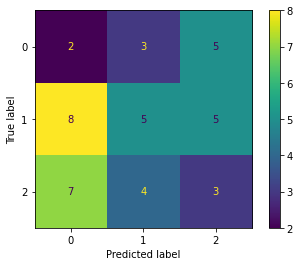

In [647]:
cm = confusion_matrix(y_test, result)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm)
cm_display.plot()
plt.show()

In [648]:
correct = 0
for i in range(len(result)):
    if result[i] == y_test[i]:
        correct += 1
print(correct/len(result))

0.23809523809523808


In [649]:
clf = RandomForestClassifier(max_depth=30, random_state=0)
clf.fit(X_train, y_train)
results = clf.predict(X_test)

In [650]:
len(results)

42

In [651]:
correct = 0
for i in range(len(results)):
    if results[i] == y_test[i]:
        correct += 1
print(correct/len(results))

0.23809523809523808


In [566]:
import torch
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(flattened_labels)
integer_encoded = integer_encoded.reshape(-1, 1)

features_tensor = torch.tensor(reshaped_features, dtype=torch.float32)
labels_tensor = torch.tensor(integer_encoded, dtype=torch.long).squeeze()
print("feature shape:", features_tensor.shape)
print("label shape:", labels_tensor.shape)
print("Unique encoded labels:", np.unique(integer_encoded))

tensor_dataset = TensorDataset(features_tensor, labels_tensor)

train_dataset, test_dataset = train_test_split(tensor_dataset, test_size=0.2, random_state=42)

train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

feature shape: torch.Size([420, 5])
label shape: torch.Size([420])
Unique encoded labels: [0 1 2]


In [568]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(5, 32)
        self.bn1 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 8)
        self.bn2 = nn.BatchNorm1d(8)
        self.fc3 = nn.Linear(8, 3)
        # self.bn3 = nn.BatchNorm1d(128)
        # self.fc4 = nn.Linear(128, 64)
        # self.bn4 = nn.BatchNorm1d(64)
        # self.fc5 = nn.Linear(64, 32)
        # self.bn5 = nn.BatchNorm1d(32)
        # self.fc6 = nn.Linear(32, 3)
        # self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.fc1(x)))
        # x = self.dropout(x)
        x = F.leaky_relu(self.bn2(self.fc2(x)))
        # x = self.dropout(x)
        x = self.fc3(x)
        # x = F.leaky_relu(self.bn3(self.fc3(x)))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.bn4(self.fc4(x)))
        # x = self.dropout(x)
        # x = F.leaky_relu(self.bn5(self.fc5(x)))
        # x = self.dropout(x)
        # x = self.fc6(x)
        return x

model = SimpleNN()

In [569]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(1000):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f"Epoch {epoch + 1}, Loss: {running_loss / len(train_loader)}")

Epoch 1, Loss: 1.1417244234505821
Epoch 2, Loss: 1.125956738696379
Epoch 3, Loss: 1.114461460534264
Epoch 4, Loss: 1.1053383841234095
Epoch 5, Loss: 1.1055223310694975
Epoch 6, Loss: 1.104511541478774
Epoch 7, Loss: 1.1034640073776245
Epoch 8, Loss: 1.0982670819058138
Epoch 9, Loss: 1.100448909927817
Epoch 10, Loss: 1.09609857376884
Epoch 11, Loss: 1.0978341944077437
Epoch 12, Loss: 1.0997849176911747
Epoch 13, Loss: 1.1026906651609085
Epoch 14, Loss: 1.103283496464
Epoch 15, Loss: 1.1012124769827898
Epoch 16, Loss: 1.097050807055305
Epoch 17, Loss: 1.0977878956233753
Epoch 18, Loss: 1.0986874945023481
Epoch 19, Loss: 1.1027502943487728
Epoch 20, Loss: 1.100023578195011
Epoch 21, Loss: 1.0988680545021505
Epoch 22, Loss: 1.0971727721831377
Epoch 23, Loss: 1.0973312539212845
Epoch 24, Loss: 1.1032539816463696
Epoch 25, Loss: 1.1003265696413376
Epoch 26, Loss: 1.097941163708182
Epoch 27, Loss: 1.0969057293499218
Epoch 28, Loss: 1.0983110771459692
Epoch 29, Loss: 1.1020097241682165
Epoch 3

In [570]:
correct = 0
total = 0
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test data: {100 * correct // total}%')

Accuracy of the network on the test data: 32%


In [52]:
range_check = data_list[1].block_sample_ranges[0]

In [56]:
test_data = data_list[1].data_dictionary['F3'][range_check[0]:range_check[1]]

In [ ]:
result = eeglib.preprocessing.bandPassFilter(test_data, sampleRate=1024, highpass=2, lowpass=45, order = 5)

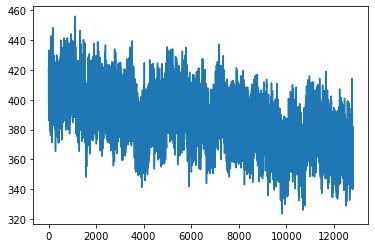

In [60]:
plt.plot(test_data)
plt.show()

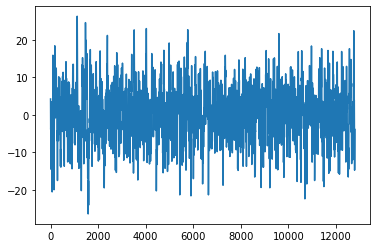

In [107]:
plt.plot(result)
plt.show()

In [126]:
print(bandpower(result, 1024, [4,8], relative = True))
bandpower(result, 1024, [4,8])

0.2088237211822282


11.539815241156433

In [127]:
print(bandpower(result, 1024, [8,12], relative = True))
bandpower(result, 1024, [8,12])

0.14022191621824373


7.32928685004221

In [128]:
print(bandpower(result, 1024, [12,30], relative = True))
bandpower(result, 1024, [12,30])

0.25136992155422816


12.109556544619416

In [129]:
print(bandpower(result, 1024, [30,45], relative = True))
bandpower(result, 1024, [30,45])

0.0


0.0

In [186]:
ca1, cd1 = pywt.dwt(result, 'db5')

In [187]:
ca2,cd2 = pywt.dwt(ca1, 'db5')

In [192]:
len(ca2)

3206

In [176]:
len(a[0])

408

<ipython-input-29-b7b995159154>:6: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  k = scipy.arange(n)


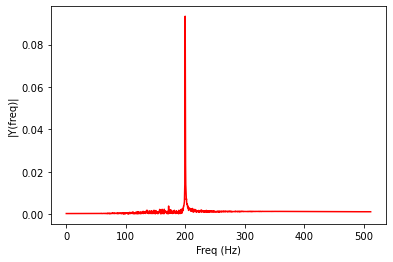

In [177]:
plotSpectrum(a[4][:-4],1024)


<ipython-input-29-b7b995159154>:6: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  k = scipy.arange(n)


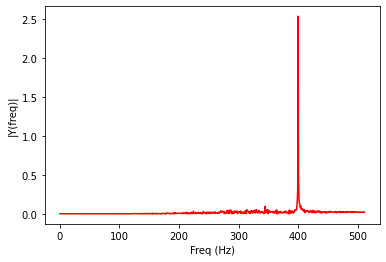

In [178]:
plotSpectrum(a[3][:-4],1024)


<ipython-input-29-b7b995159154>:6: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  k = scipy.arange(n)


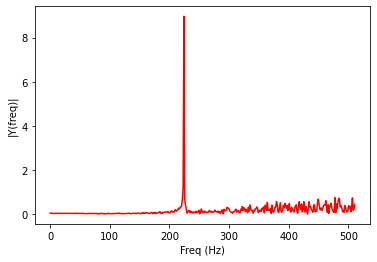

In [179]:
plotSpectrum(a[2][:-4],1024)

<ipython-input-29-b7b995159154>:6: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  k = scipy.arange(n)


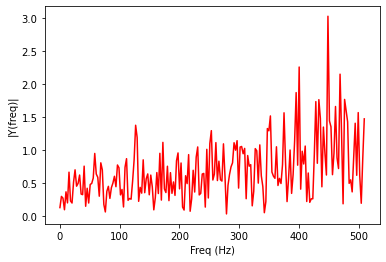

In [180]:
plotSpectrum(a[1][:-4], 1024)


<ipython-input-29-b7b995159154>:6: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  k = scipy.arange(n)


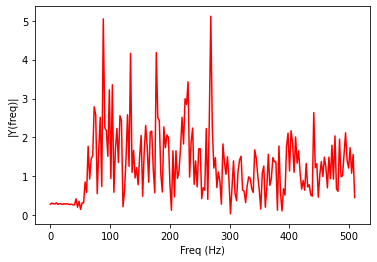

In [181]:
plotSpectrum(a[0][:-4], 1024)
# plt.show()

In [141]:
a,b,c,d,e

6

In [137]:
len(wavelets[1])

6404